
# XGBoost in Python for Customer Churn Prediction

#### Tattwa Darshi Panda, Data Scientist, Hong Kong

----

In this project we use **XGBoost** to build a collection of boosted trees (one of which is illustrated below), and use continuous and categorical data from the **[IBM Base Samples](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2018/09/12/base-samples-for-ibm-cognos-analytics)** to predict whether or not a customer will **[stop using a company's service](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)**. In business lingo, this is called **Customer Churn**. You can download the **[Telco Churn dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2017/06/19/guide-to-ibm-cognos-analytics-sample-data-sets)**, or use the file provided with the jupyter notebook.

<!-- <img src="./xgboost_tree.png" alt="An XGBoost Tree" style="width: 600px;"> -->
<img src="./xgboost_tree_customer_churn.png" alt="An XGBoost Tree">

**XGBoost** is an exceptionally useful machine learning method when you don't want to sacrifice the ability to correctly classify observations but you still want a model that is fairly easy to understand and interpret. 

In this project we will do the following:

- **[Importing Data from a File](#download-the-data)**

- **[Missing Data](#identify-and-deal-with-missing-data)**
    - Identifying Missing Data
    - Dealing with Missing Data


- **[Formatting the Data for XGBoost](#format-the-data)**

    - Splitting data into Dependent and Independent Variables
    - One-Hot-Encoding
    - Converting all columns to Int, Float or Bool
    

- **[Building a Preliminary XGBoost Model](#build-tree)**


- **[Optimizing Parameters with Cross Validation and GridSearch()](#optimize-parameters)**
    
    - Optimizing the learning rate, tree depth, number of trees, gamma (for pruning) and lambda (for regularization).


- **[Building, Drawing, Interpreting and Evaluating the Optimized XGBoost Model](#draw-tree)**


# Import the modules that will do all the work
The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the **XGBoost** model. 

**NOTE:** You will need **Python 3** and have at least these versions for each of the following modules: 
- pandas >= 1.2.3
- numpy >= 1.19.2
- sklearn >= 0.24.1
- xgboost >= 1.3.3
 
If you installed **Python 3** with [Anaconda](https://www.anaconda.com/), you can check which versions you have with the command: `conda list`. If, for example, your version of `scikit-learn` is older than 0.22.1, then the easiest thing to do is just update all of your **Anaconda** packages with the following command: `conda update --all`. However, if you only want to update `scikit-learn`, then you can run this command: `conda install scikit-learn=0.22.1`.

If you need to install `xgboost`, then you can do so with the following command: `conda install -c conda-forge xgboost`.

**NOTE:** To draw the tree, you will also need to install `graphviz`. You can do that with the command: `conda install graphviz python-graphviz`.

In [1]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[IBM Base Samples](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2018/09/12/base-samples-for-ibm-cognos-analytics)**. Specifically, we are going to use the **[Telco Churn Dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2017/06/19/guide-to-ibm-cognos-analytics-sample-data-sets)**. This dataset will allow us to predict if someone will stop using Telco's services or not using a variety of continuous and categorical datatypes.


**NOTE:** When **pandas** (**pd**) reads in data, it returns a **data frame**, which is a lot like a spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable name for a **data frame** is the initials **df**, and that is what we will use here:

In [2]:
df = pd.read_csv('Telco_customer_churn.csv')

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

In [3]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


The "..." between **Gender** and **Contract** tells us that this dataset has more columns, or variables, than will print to the screen. And the `5 rows x 33 columns` printed below the first 5 rows tells us that there are 33 variables. The last four variables contain exit interview information and should not be used for prediction, so we will remove them.

In [3]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'],
        axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Some of the other columns only contain a single value, and will not be useful for classification. For example:

In [4]:
df['Count'].unique()

array([1], dtype=int64)

In [5]:
df['Country'].unique()

array(['United States'], dtype=object)

In [6]:
df['State'].unique()

array(['California'], dtype=object)

So we can omit those variables. In contrast, `City` contains a bunch of different city names, so we will leave it in. 

In [7]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

We will also remove `Customer ID` because it is different for every customer and useless for classification. Lastly, we will drop `Lat Long` because there are separate columns for `Latitude` and `Longitude`.

In [8]:
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'],
        axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


**NOTE:** Although it is OK to have whitespace in the city names in **City** for **XGBoost** and classification, we can't have any whitespace if we want to draw a tree. So let's take care of that now by replacing the white space in the city names with an underscore character `_`.

**ALSO NOTE** We can easily remove whitespaces from all values, not just city names, but we will wait to do that until after we have identified missing values.

In [9]:
df['City'].replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [10]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

We also need to eliminate the whitespace in the column names, so we'll replace it with underscores. 

In [11]:
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


We have removed all of the data that will not help use create an effective **XGBoost** model and reformatted the column names and city names so that we can draw a tree. Now we are ready to identify and deal with **Missing Data**.


----

<a id="identify-and-deal-with-missing-data"></a>
# Missing Data Part 1: Identifying Missing Data

Unfortunately, the biggest part of any data analysis project is making sure that the data are correctly formatted and fixing it when it is not. The first part of this process is identifying **Missing Data**.

**Missing Data** is simply a blank space, or a surrogate value like **NA**, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

One thing that is relatively unique about **XGBoost** is that it has default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

In this section, we'll focus on identifying missing values in the dataset. 

First, let's see what sort of data is in each column.

In [12]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

A lot of the columns are `object`, and this is OK, because, as we saw above when we ran `head()` there were a lot of text responses, like `Yes` and `No`. However, let's verify that we are getting what we expect.

In [13]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

So, **Phone_Service** has type `object` because it contains text, and it only contains two values, `Yes` and `No`. So this is good. Now, in practice, we would check every other column, and I did this, but right now we will focus on one specific column that looks like it could be a problem: **Total_Charges**.

If we look at the output from `head()`, **Total_Charges** looks like it contains numbers, not text, but the `object` datatype suggests that it contains more than just numbers. If we try the trick of printing out the unique values...

In [15]:
df['Total_Charges'].unique()

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

...we see that there are too many values to print and what little we see looks like numbers. However, if we try to convert the column to numeric values...

In [16]:
## NOTE: The next line is commented out, but you should
## uncomment it and run it so you can see the error that it
## generates.
##
## The only reason it is commented out is that if you want
## to just run all of the Python code at once, the next line
## will cause Python to quit early because it creates an error
## 
## However, the error is useful for learning how to spot missing
## data, so that is why you should uncomment it and run it if you can.

## df['Total Charges'] = pd.to_numeric(df['Total_Charges'])

...we get an error. This error, however, tells us what the problem is. There are blank spaces, `" "`, in the data. So we need to deal with those.


----


# Missing Data Part 2: Dealing With Missing Data, XGBoost Style

One thing that is relatively unique about **XGBoost** is that it determines default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

However, before we do that, let's see how many rows are missing data. If it's a lot, then we might have a problem on our hands that is bigger than what **XGBoost** can deal with on its own. If it's not that many, we can just set them to `0`.

In [17]:
len(df.loc[df['Total_Charges'] == ' '])

11

Since only **11** rows have missing values, let's look at them.

In [18]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We see that all **11** people with `Total_Charges == ' '` have just signed up, because **Tenure_Months** is `0`. These people also all have **Churn_Value** set to `0` because they just signed up. So we have a few choices here, we can set **Total_Charges** to `0` for these **11** people or we can remove them. In this example, we'll try setting **Total_Charges** to `0`.

In [19]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0

Now let's verify that we modified **Total Charges** correctly by looking at everyone who had **Tenure Months** set to `0`.

In [24]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


**BAM!** We have verified that `df` contains `0`s instead of `' '`s for missing values. **NOTE:** **Total_Charges** still has the `object` data type. That is no good because **XGBoost** only allows `int`, `float` or `boolean` data types. We can fix this by converting it with `to_numeric()`.

In [20]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

Now that we have dealt with the missing data, we can replace all of the other whitespaces in all of the columns with underscores. 
**NOTE:** we are only doing this so we can draw a picture of the one of the **XGBoost** trees.

In [21]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


In [27]:
df.size

169032

----

<a id="format-the-data"></a>
# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making an **XGBoost** model.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **Churn Value** (whether or not someone will leave the company).

The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and  remove the missing values etc.

In [22]:
X = df.drop('Churn_Value', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [23]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready to continue formatting **X** so that it is suitable for making a model with **XGBoost**.

----

<a id="one-hot-encoding"></a>
# Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **City** - **Category**
  - Los Angeles, Beverly Hills, etc.
- **Zip Code** - **Category**
  - 90003, 90005, etc.
- **Latitude** - **Float**
- **Longitude** - **Float**
- **Gender** - **Category**
  - Female, Male
- **Senior Citizen** - **Category**
  - Yes, No
- **Partner** - **Category**
  - Yes, No
- **Dependents** - **Category**
  - Yes, No
- **Tenure Months** - **Float**
- **Phone Service** - **Category**
  - Yes, No
- **Multiple Lines** - **Category**
  - Yes, No
- **Internet Service** - **Category**
  - No, DSL, Fiber optic
- **Online Security** - **Category**
  - Yes, No
- **Online Backup** - **Category**
  - Yes, No
- **Device Protection** - **Category**
  - Yes, No
- **Tech Support** - **Category**
  - Yes, No
- **Streaming TV** - **Category**
  - Yes, No
- **Streaming Movies** - **Category**
  - Yes, No
- **Contract** - **Category**
  - Month-to-month, One year, Two year
- **Paperless Billing** - **Category**
  - Yes, No
- **Payment Method** - **Category**
  - Mailed check, Electronic check, etc...
- **Monthly Charges** - **Float**
- **Total Charges** - **Float**


Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

In [24]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

So, we see that **Latitude**, **Longitude**, **Monthly_Charges** and **Total_Charges** are all `float64`, which is good, because we want them to be floating point numbers. All of the columns that are `object` type, however, need to be inspected to make sure they only contain reasonable values, and most, if not all of them, will need to change. This is because, while **XGBoost** natively supports continuous data, like **Monthly_Charges** and **Total_Charges**, it does not natively support categorical data, like **Phone_Service**, which contains 2 different categories. Thus, in order to use categorical data with **XGBoost**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

"what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **Payment_Method** column, we have a bunch of options:
1. Mailed_Check
2. Electronic_Check
3. Bank_Transfer
4. Credit_Card

If we converted these categories to numbers, 1, 2, 3 and 4, treated them like continuous data, then we would assume that 4, which means **Credit_Card**, is more similar to 3, which means **Bank_Transfer**, than it is to 1 or 2, which are other forms of payment. That means the **XGBoost Tree** would be more likely to cluster the people with 4s and 3s together than the people with 4s and 1s together. In contrast, if we treat these **Payment_Methods** like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering people who pay with a **Mailed_Check** with people who pay with **Electronic_Check** is the same as clustering **Mailed_Check** with **Credit_Card**, and that approach is more reasonable.

<!-- Now we need to deal with **cp** (chest pain), **restecg** (resting electrocardiographic results), **slope** (the slope of the peak exercise ST segment) and **thal** (thalium heart scan).
 -->
**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **XGBoost** model using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **XGBoost** model is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and loses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`.

First, before we commit to converting columns with **One-Hot Encoding**, let's just see what happens when we convert **Payment_Method** without saving the results. This will make it easy to see how `get_dummies()` works.

In [25]:
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process in the front and it puts the values for **Payment_Method** at the end, split into **4** columns, just like we expected it. **Payment_Method_Bank_transfer** is `1` for any person that paid by **Bank_transfer** and `0` for everyone else. Likewise, **Payment_Method_Credit_card** is `1` for anyone that paid with **Credit_card** and `0` for everyone else. 

Now that we see how `get_dummies()` works, let's use it on all of the categorical columns and save the result.

In [26]:
X_encoded = pd.get_dummies(X, columns=['City', 
                                       'Gender', 
                                       'Senior_Citizen', 
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support',
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


Now, one last thing before we build an **XGBoost** model.  Let's verify that `y` only contains **1s** and **0s** with `unique()`:

In [27]:
y.unique()

array([1, 0], dtype=int64)


----

<a id="build-tree"></a>
# Build A Preliminary XGBoost Model
At long last, the data is correctly formatted for making an **XGBoost** model. Now we simply split the data into **training** and **testing** data sets and build the model. However, first, let's observe that this data is imbalanced by dividing the number of people who left the company, where `y = 1`, by the total number of people in the dataset. 

In [28]:
sum(y)/len(y)

0.2653698707936959

So we see that only **27%** of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the **training** set and the **testing** set.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Now let's verify that using `stratify` worked as expected...

In [30]:
sum(y_train)/len(y_train)

0.2654297614539947

In [38]:
sum(y_test)/len(y_test)

0.26519023282226006

**BAM!!!** `stratify` worked as expected and both `y_train` and `y_test` have the same percentage of people that left the company. Now let's build the preliminary model.

**NOTE:** Instead of determining the optimal number of trees with cross validation, we will use **early stopping** to stop building trees when they no longer improve the situation.

In [31]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric="logloss", ## this avoids a warning...
                            missing=None, seed=42, 
                            use_label_encoder=False)
## NOTE: newer versions of XGBoost will issue a warning if you don't explitly tell it that
## you are not expecting it to do label encoding on its own (in other words, since we
## have ensured that the categorical values are all numeric, we do not expect XGBoost to do label encoding), 
## so we set use_label_encoder=False
clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            ## the next three arguments set up early stopping.
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])
## NOTE: In the video I got 50 or 60 lines of output. However, the newer version of XGBoost is faster and only prints out 20.

[01:19:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.64036
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65051
[4]	validation_0-aucpr:0.65321
[5]	validation_0-aucpr:0.64854
[6]	validation_0-aucpr:0.65459
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65850
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66527
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66000
[15]	validation_0-aucpr:0.66027
[16]	validation_0-aucpr:0.65781
[17]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

OK, we've built an **XGBoost** model for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

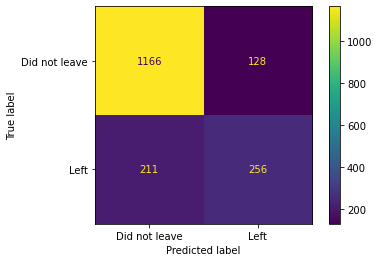

In [32]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not leave", "Left"])

<!-- NOTE: because we included the missing data, we get different training/testing dataset from SVM and classification trees, so we get different results etc.
 -->
In the confusion matrix, we see that of the **1294** people that **did not leave**, **1166 (90%)** were correctly classified. And of the **467** people that **left the company**, **256 (54%)** were correctly classified. So the **XGBoost** model was not awesome. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing **1262** people that did not default and the bottom row showing **467** people who did. Because people leaving costs the company a lot of money, we would like to capture more of the people that left. The good news is that **XGBoost** has a parameter, `scale_pos_weight`, that helps with imbalanced data. So let's try to improve predictions using **Cross Validation** to optimize the parameters.

----

<a id="optimize-parameters"></a>
# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manually configure and are not determined by **XGBoost** itself, including `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, and `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [41]:
# ## NOTE: When data are imbalanced, the XGBoost manual says...
# ## If you care only about the overall performance metric (AUC) of your prediction
# ##     * Balance the positive and negative weights via scale_pos_weight
# ##     * Use AUC for evaluation
# ## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
# ## in order to optimize parameters in a short period of time.

# # ROUND 1
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5] # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
# }
# # Output: max_depth: 4, learning_rate: 0.1, gamma: 0.25, reg_lambda: 10, scale_pos_weight: 3
# # Because learning_rate and reg_lambda were at the ends of their range, we will continue to explore those...

# ## ROUND 2
# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.1, 0.5, 1],
#     'gamma': [0.25],
#     'reg_lambda': [10.0, 20, 100],
#      'scale_pos_weight': [3]
# }
# ## Output: max_depth: 4, learning_rate: 0.1, reg_lambda: 10.

# NOTE: To speed up cross validiation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only
# using a random subset of the features (columns) (50%) per tree.
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', 
#                                 eval_metric="logloss", ## this avoids a warning...
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5,
#                                 use_label_encoder=False),
#     param_grid=param_grid,
#     scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
#     n_jobs = 10,
#     cv = 3
# )

# optimal_params.fit(X_train, 
#                    y_train, 
#                    early_stopping_rounds=10,                
#                    eval_metric='auc',
#                    eval_set=[(X_test, y_test)],
#                    verbose=False)
# print(optimal_params.best_params_)

So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=0.25`, `learn_rate=0.1`, `max_depth=4`, and `reg_lambda=10`.

----

<a id="draw-tree"></a>
# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [33]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="logloss", ## this avoids warning...
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[01:20:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.56622
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.59525
[2]	validation_0-aucpr:0.62515
[3]	validation_0-aucpr:0.62633
[4]	validation_0-aucpr:0.63192
[5]	validation_0-aucpr:0.63171
[6]	validation_0-aucpr:0.62947
[7]	validation_0-aucpr:0.63056
[8]	validation_0-aucpr:0.63608
[9]	validation_0-aucpr:0.63616
[10]	validation_0-aucpr:0.63627
[11]	validation_0-aucpr:0.65626
[12]	validation_0-aucpr:0.65366
[13]	validation_0-aucpr:0.65374
[14]	validation_0-aucpr:0.65623
[15]	validation_0-aucpr:0.64859
[16]	validation_0-aucpr:0.64615
[17]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.25, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

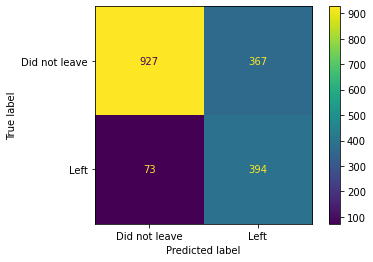

In [34]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not leave", "Left"])

We see that the optimized **XGBoost** model is a lot better at identifying people that left the company. Of the **467** people that left the company, **390 (84%)**, were correctly identified. Before optimization, we only correctly identified **256 (54%)**. However, this improvement was at the expense of not being able to correctly classify as many people that did not leave. Before optimization, we correctly identified **1,166 (90%)** people that did not leave. Now we only correctly classify **937 (72%)**. That said, this trade off may be better for the company because now it can focus resources on the people that leave if that will help them retain them.

In [35]:
cmat = [[ 927,  367], 
        [73, 394]]

def myscores(smat): 
    tp = smat[0][0] 
    fp = smat[0][1] 
    fn = smat[1][0] 
    tn = smat[1][1] 
    return tp/(tp+fp), tp/(tp+fn)

In [36]:
print("precision and recall:", myscores(cmat))


precision and recall: (0.7163833075734157, 0.927)


The last thing we are going to do is draw the first **XGBoost Tree** and discuss how to interpret it.

[01:21:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


weight:  {'Tech_Support_No': 1, 'Contract_Two_year': 1, 'Internet_Service_Fiber_optic': 1, 'Tenure_Months': 5, 'Monthly_Charges': 2, 'Latitude': 1, 'Internet_Service_DSL': 2, 'Contract_One_year': 1, 'Senior_Citizen_No': 1}
gain:  {'Tech_Support_No': 1133.81055, 'Contract_Two_year': 252.511536, 'Internet_Service_Fiber_optic': 134.158798, 'Tenure_Months': 112.87569578000003, 'Monthly_Charges': 13.625781100000001, 'Latitude': 6.79351807, 'Internet_Service_DSL': 85.56891250000001, 'Contract_One_year': 13.2877808, 'Senior_Citizen_No': 14.3072205}
cover:  {'Tech_Support_No': 1820.25, 'Contract_Two_year':

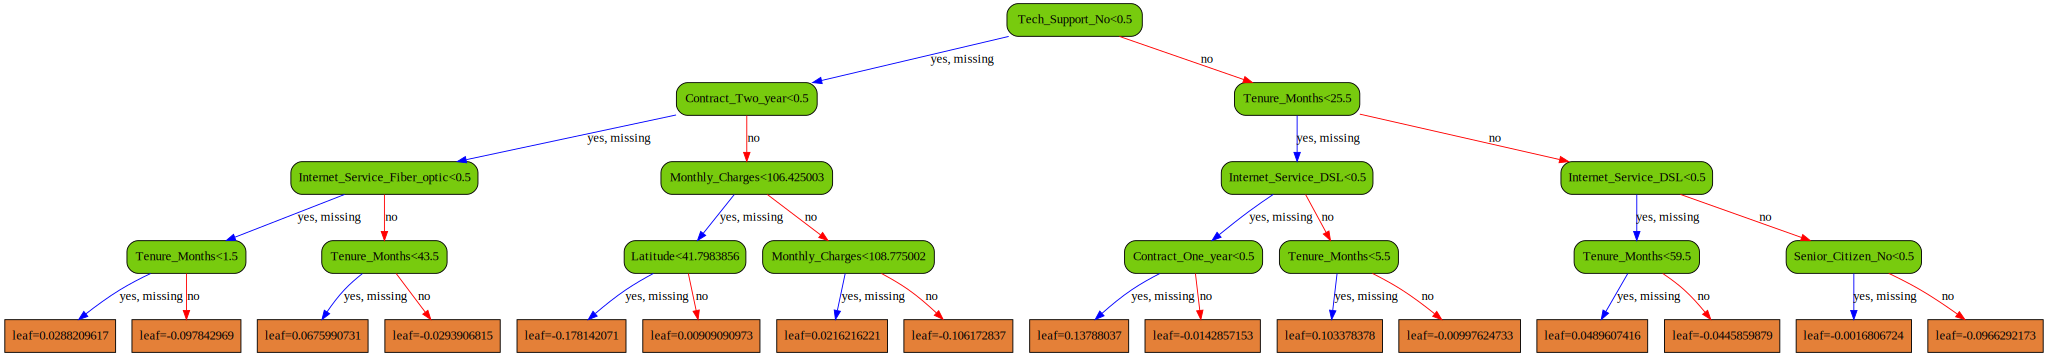

In [37]:
## If we want to get information, like gain and cover etc, at each node in the first tree, 
## we just build the first tree, otherwise we'll get the average over all of the trees.
clf_xgb = xgb.XGBClassifier(seed=42,
                        eval_metric="logloss", ## this avoids another warning...
                        objective='binary:logistic',
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        n_estimators=1, ## We set this to 1 so we can get gain, cover etc.)
                        use_label_encoder=False) 

clf_xgb.fit(X_train, y_train)

## now print out the weight, gain, cover etc. for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average gain across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover = the total coverage across all splits the feature is used in
## NOTE: Since we only built one tree, gain = total_gain and cover=total_cover
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
## NOTE: num_trees is NOT the number of trees to plot, but the specific tree you want to plot
## The default value is 0, but I'm setting it just to show it in action since it is
## counter-intuitive.
# xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10") 
## NOTE: I have heard that on windos you may need to add the
## the exectuables for graphviz to your path for this next code to work.
## For example, if graphviz is here: C:/Users/User/anaconda3/Library/bin/graphviz
## Then you may need to run the following line of code (adjusting the path as needed)
# os.environ["PATH"]+= os.pathsep + 'C:/Users/User/anaconda3/Library/bin/graphviz'
xgb.to_graphviz(clf_xgb, num_trees=0, 
                condition_node_params=node_params,
                leaf_node_params=leaf_params) 
## if you want to save the figure...
# graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", 
#                 condition_node_params=node_params,
#                 leaf_node_params=leaf_params) 
# graph_data.view(filename='xgboost_tree_customer_churn') ## save as PDF

Now let's discuss how to interpret the **XGBoost Tree**.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **Contract_Month-to-month** to split the observations. All observations with **Contract_Month-to-month < 1** go to the **left** and all observations with **Contract_Month-to-month =< 1** go to the **right**.
- Each branch either says **yes** or **no** and some also say **missing**. 
 - **yes** and **no** refer to whether the threshold in the node above it is true or not. If so, then **yes**, if not, then **no**. 
 - **missing** is the default option if there is missing data.
- **leaf** tells us the output value for each leaf.

-----

# In conclusion we performed the following:

- **[Loaded the Data From a File](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Formatted the Data for XGBoost using One-Hot Encoding](#one-hot-encoding)**

- **[Built an XGBoost Model for Classification](#build-tree)**

- **[Optimize the XGBoost Parameters with Cross Validation and GridSearch()](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Optimized XGBoost Model](#draw-tree)**

 We will draw **[SHAP](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html)** plots that will show which features are most important for the model. To do this, you need to have the `shap` package installed. You can do this with `conda install -c conda-forge shap`. Now let's import `shap`...

In [38]:
import shap

...and rebuild the optimal **xgboost** model...

In [48]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="logloss", ## this avoids warning...
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[14:53:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.56622
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.59525
[2]	validation_0-aucpr:0.62515
[3]	validation_0-aucpr:0.62633
[4]	validation_0-aucpr:0.63192
[5]	validation_0-aucpr:0.63171
[6]	validation_0-aucpr:0.62947
[7]	validation_0-aucpr:0.63056
[8]	validation_0-aucpr:0.63608
[9]	validation_0-aucpr:0.63616
[10]	validation_0-aucpr:0.63627
[11]	validation_0-aucpr:0.65626
[12]	validation_0-aucpr:0.65366
[13]	validation_0-aucpr:0.65374
[14]	validation_0-aucpr:0.65623
[15]	validation_0-aucpr:0.64859
[16]	validation_0-aucpr:0.64615
[17]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.25, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Now we get `shap` to create summaries of the data...

In [39]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

...and draw a **SHAP** graph that summarizes the features.

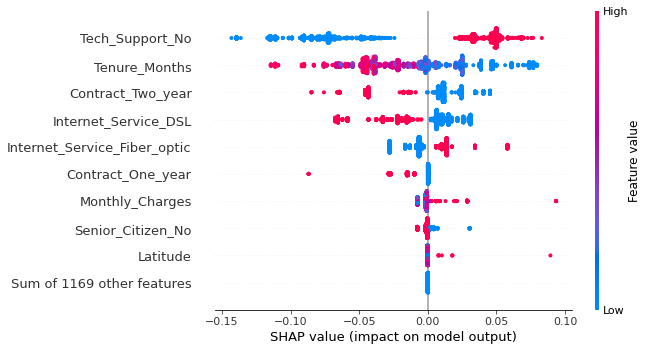

In [40]:
shap.plots.beeswarm(shap_values)